In [12]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [13]:
(trainX,trainY),(testX,testY)=mnist.load_data()

In [14]:
print(trainX[0])
trainX.shape

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

(60000, 28, 28)

trainX was originally a 2D array with shape (samples, features), then after applying np.expand_dims(trainX, axis=-1), it would become a 3D array with shape (samples, features, 1). This can be helpful when working with convolutional neural networks (CNNs) that require a certain input shape.

In [15]:
trainX=np.expand_dims(trainX,axis=-1)
testX=np.expand_dims(testX,axis=-1)

In [16]:
print(trainX.shape)


(60000, 28, 28, 1)


Normalizing data

In [17]:
trainX=trainX/255.0
testX=testX/255.0

Pictures Without Noise

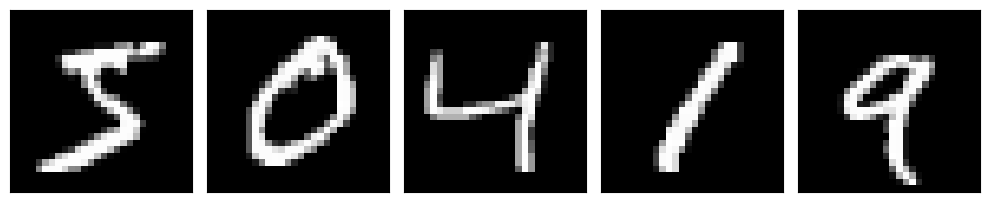

In [18]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i].reshape(28,28),cmap='gray')  
plt.tight_layout()
# This line ensures that the subplots are laid out neatly within the figure, with appropriate spacing and padding.
plt.show()

As mnist images dosent have noise, we have to add noise to test our autoencoder

In [19]:
trainNoise = np.random.normal(loc=0.5,scale=0.5,size=trainX.shape)
testNoise = np.random.normal(loc=0.5,scale=0.5,size=testX.shape)
trainXNoisy = np.clip(trainX+trainNoise,0,1)
testXNoisy = np.clip(testX+testNoise,0,1)

The np.random.normal() function is used to generate random values from a normal distribution. The parameters are as follows:
  * loc: Mean of the distribution (center of the distribution).
  * scale: Standard deviation of the distribution (spread or magnitude of the noise). 
  * size: Shape of the array to be generated, which corresponds to the shape of the trainX and testX arrays.

So, trainNoise and testNoise will be arrays of the same shape as trainX and testX, respectively, containing random values sampled from a normal distribution with a mean of 0.5 and a standard deviation of 0.5.


The addition of noise is performed element-wise, meaning each pixel value of the images is modified by adding a corresponding noise value.

The np.clip() function is then used to ensure that the resulting noisy images have pixel values within the range [0, 1]. 

Pictures After adding Noise

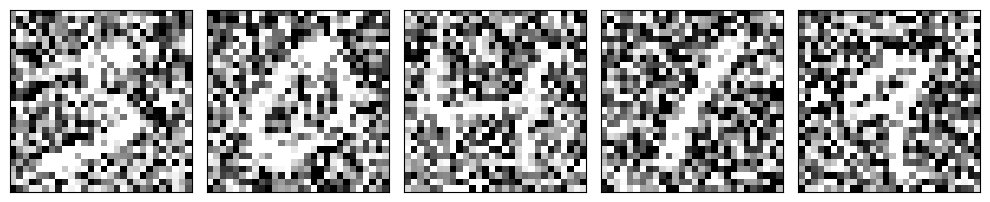

In [20]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainXNoisy[i].reshape(28,28),cmap="gray")
plt.tight_layout()
plt.show()

Archetecture

In [21]:
import tensorflow as tf


In [22]:
def encode(model):
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(28,28,1),padding="same"))
    model.add(tf.keras.layers.MaxPooling2D((2,2),padding="same"))
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
    model.add(tf.keras.layers.MaxPooling2D((2,2),padding="same"))

def decode(model):
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
    model.add(tf.keras.layers.UpSampling2D(size=(2,2)))
    model.add(tf.keras.layers.Conv2D(32,(3,3),activation="relu",padding="same"))
    model.add(tf.keras.layers.UpSampling2D(size=(2,2)))
    model.add(tf.keras.layers.Conv2D(1,(3,3),activation="sigmoid",padding="same"))


In [23]:
autoencoder=tf.keras.Sequential()
encode(autoencoder)
decode(autoencoder)


autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 32)        0

In [24]:
autoencoder.compile(
    optimizer="adadelta",
    loss="binary_crossentropy",
)

In [26]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.15):
            print("Loss Reached below 0.15 so< Cancelling the training")
            self.model.stop_training=True

callback=MyCallback()

Training CNN autoencoder

In [27]:
train=autoencoder.fit(
    trainXNoisy, trainX,
    epochs=100,
    validation_data=(testXNoisy,testX),
    batch_size=32,
    callbacks=[callback]
)

Epoch 1/100
1875/1875 [==============================] - 29s 16ms/step - loss: 0.6037 - val_loss: 0.4897
Epoch 2/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4714 - val_loss: 0.4592
Epoch 3/100
1875/1875 [==============================] - 28s 15ms/step - loss: 0.4347 - val_loss: 0.4117
Epoch 4/100
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3757 - val_loss: 0.3415
Epoch 5/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3091 - val_loss: 0.2864
Epoch 6/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2730 - val_loss: 0.2631
Epoch 7/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2560 - val_loss: 0.2495
Epoch 8/100
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2444 - val_loss: 0.2390
Epoch 9/100
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2350 - val_loss: 0.2302
Epoch 10/100
1875/1875 [==============================]

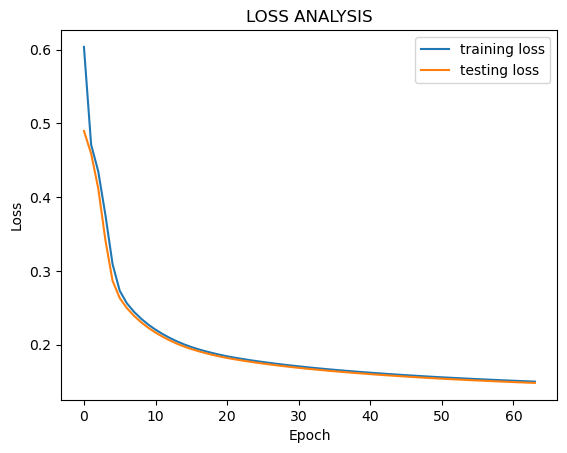

In [28]:

plt.plot(train.history['loss'],label="training loss")
plt.plot(train.history["val_loss"],label="testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LOSS ANALYSIS")
plt.legend(loc="upper right")
plt.show()

Pridicting The Reconstructed Images For the Original Images

In [29]:
predicted_images=autoencoder.predict(testXNoisy)

313/313 [==============================] - 1s 4ms/step


Visualizing Our Results

Original Test Images:

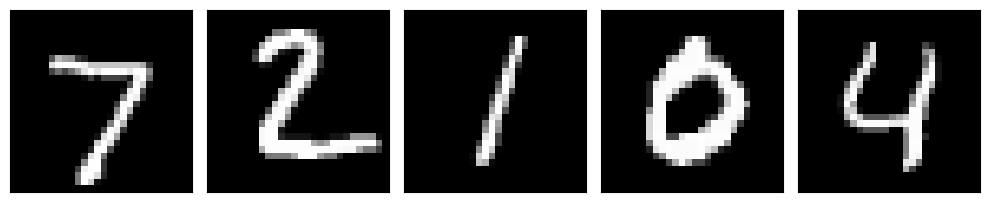

In [30]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i].reshape(28,28),cmap="gray")
plt.tight_layout()
plt.show()


Noisy Test Images

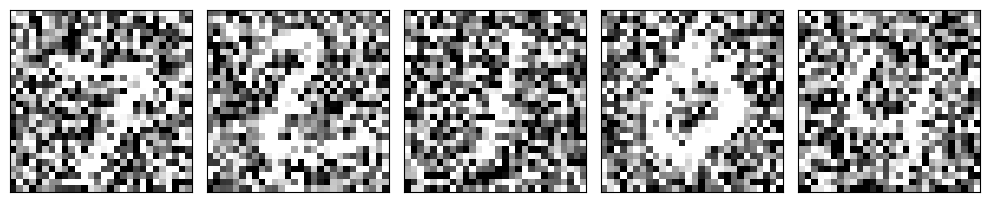

In [31]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testXNoisy[i].reshape(28,28),cmap="gray")
plt.tight_layout()
plt.show()


Reconstructed Images with Our Autoencoder

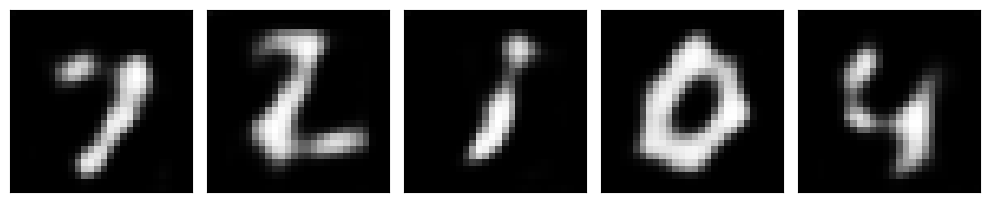

In [32]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(predicted_images[i].reshape(28,28),cmap="gray")
plt.tight_layout()
plt.show()
